# LSTM Model

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from models.simple_LSTM import *
from models.train_LSTM_utils import train, k_fold
from models.early_stopping import EarlyStopping
from data.LSTM_dataset import LSTMDataset
from models.metrics import *


/home/chau/miniconda3/envs/ml_project2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/chau/Desktop/Projects/ml-project-2-ml-sonidito/notebook/../src/models/train_LSTM_utils.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import matplotlib

font = {'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (10, 5)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Load Dataset

In [4]:
torch.manual_seed(0)
np.random.seed(0)

dataset = LSTMDataset('../data',
                      max_length=4293)


data processing:  25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

data processing: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

deleted 1 data that doesn't have any mode


In [5]:
dataset.features_selection = ['max_energies', 'N1']

In [6]:
size = int(len(dataset) * 0.9)

train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=128)
print(f'train size : {len(train_set)}, val size : {len(test_set)}')

train size : 2, val size : 1


In [7]:
# Used to compute Min Max of each feature for the normalization
# Don't forget to remove any normalization in the dataset to compute these values

# for key in dataset.features[0].keys():
#     feature = []
#     for idx in train_set.indices :
#         item = dataset.features[idx]
#         feature += item[key]
#     feature = np.array(feature)
#     print(f'key={key}, min={feature.min()}, max={feature.max()}')

## Compute `pos_weight`

We have a unbalanced dataset, to rebalance the dataset, we add a weight for positive value. The pos_weight is equal to $\frac{\text{total}}{\text{number of pos}} $

In [8]:
def compute_pos_weight(data):
    size = 0
    nb_pos = 0
    for item in data:
        labels = item[1]
        size += len(labels.flatten())
        nb_pos +=(labels == 1).sum()
    print(f'size={size}, nb_pos={nb_pos}')
    return (size - nb_pos) / nb_pos

compute_pos_weight(train_loader)

size=8586, nb_pos=146


/home/chau/Desktop/Projects/ml-project-2-ml-sonidito/notebook/../src/data/LSTM_dataset.py:116: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/pytorch-select_1700158693612/work/torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(input, dtype=torch.float32).swapaxes(0,1), self.labels[idx]


tensor(57.8082)

## Init Model

In [9]:
input_size = dataset[0][0].shape[1]
print(f'input_size={input_size}')
hidden_size = 2**8
num_layers = 1
lr = 0.001
weight_decay = 1e-06
l1_sigma = 0
dropout_rate = 0

pos_weight = compute_pos_weight(train_loader) # size / # pos

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

patience=10
delta=1e-2
model_path = '../models/lstm.pt'

print(model)    
print(optimizer)
print(criterion)
print(f'l1_sigma={l1_sigma}')

input_size=2
size=8586, nb_pos=146


The model has 310,145 trainable parameters
SimpleLSTM(
  (lstm): LSTM(2, 256, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=8, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-06
)
BCEWithLogitsLoss()
l1_sigma=0


## Model training

100%|██████████| 1/1 [00:33<00:00, 33.63s/it, score=0, train_loss=1.36]


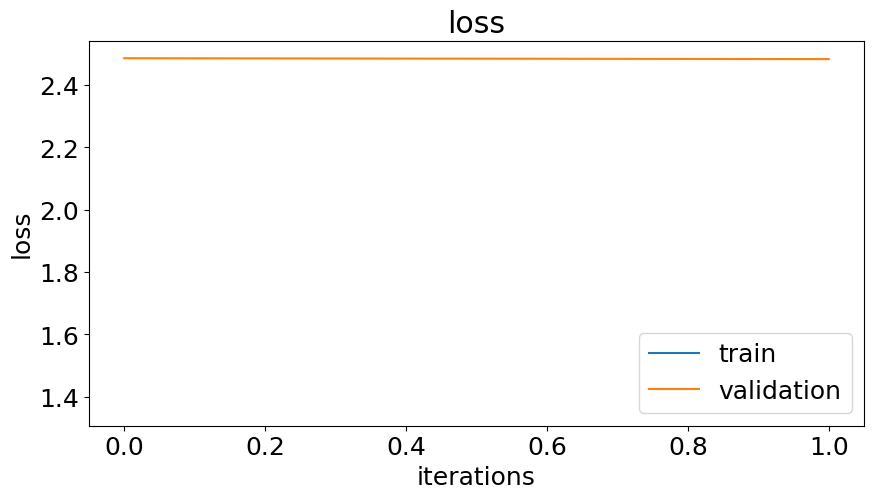

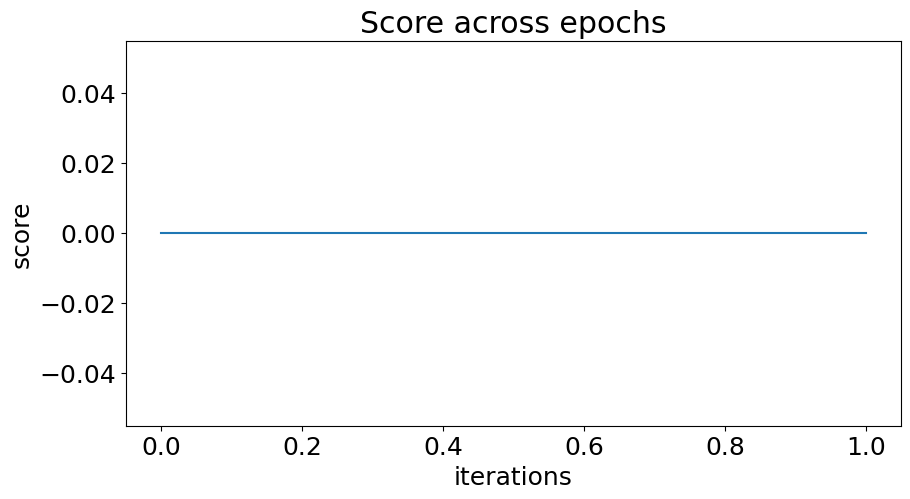

In [11]:
from data.LSTM_dataset import create_preds

def comptue_score(logits, labels):
      logits = torch.sigmoid(logits).detach()
      preds = create_preds(logits)
      return compute_kappa_score(preds, labels)

train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      compute_objective=comptue_score,
      n_epochs=1,
      l1_sigma=l1_sigma,
      direction="maximize",
      patience=patience,
      delta=delta,
      model_path=model_path)

## Model evaluation

kappa=0.0


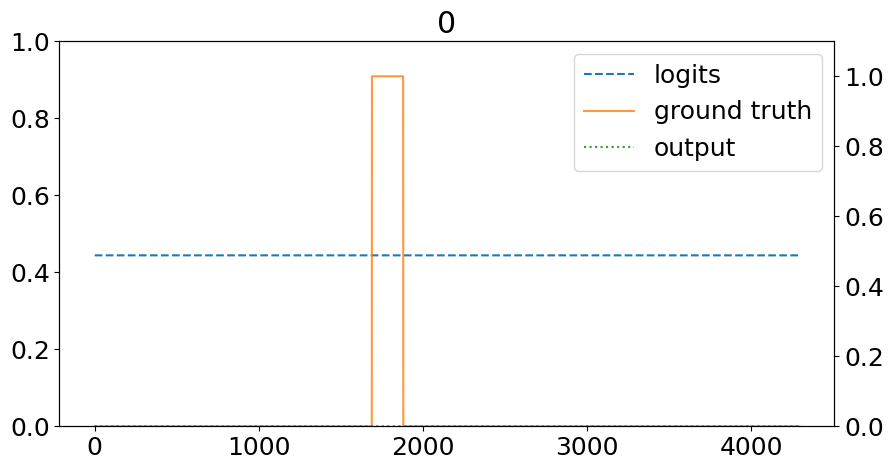

0.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from models.metrics import *


model.eval()
model.to(device)
with torch.no_grad():
    for idx in np.random.choice(len(test_set), len(test_set), replace=False): 
        testing_data = test_set[idx]
        logits = torch.sigmoid(model(testing_data[0].to(device))).detach().cpu()
        preds = create_preds(logits.unsqueeze(0))
        print(f'kappa={compute_kappa_score(preds == 1, testing_data[1].unsqueeze(0)).item()}')

        fig, ax = plt.subplots()

        plt.title(idx)
        ax1 = ax.twinx()
        ax1.plot(logits.numpy(), label='logits', linestyle='--' )
        ax1.plot(testing_data[1], label='ground truth', alpha=0.8)
        ax1.plot(preds.squeeze(), label='output', linestyle=':')
        # for idx in range(testing_data[0].shape[1]):
        #     data = testing_data[0][:,idx]
        #     if (data <= 0).all() :
        #         data *= -1
        #         ax.plot(testing_data[0][:,idx], alpha =0.3)
        #     else :
        #         ax.plot(testing_data[0][:,idx], alpha =0.3)
        # ax.plot(testing_data[0][:,0], label='max energies', alpha=0.3)
        # ax1.plot(testing_data[0][:,1], label='N1', alpha=0.3)
        ax1.legend()
        ax1.set_ylim(0, 1.1)
        plt.show()

    kappa = []

    for (x_batch, shotno), y_batch in val_loader :
        x_batch = x_batch.to(device)
        
        logits = torch.sigmoid(model(x_batch)).detach().cpu()
        preds = create_preds(logits)

        kappa += compute_kappa_score(preds, y_batch)

    print(np.mean(kappa))

## Grid Search

In [ ]:
# import json
# from tqdm import tqdm

# k = 6
# n_epochs = 200

# search_res = []

# best_hyper = None
# evaluation_metric = 'kappa'

# hyperparams = []

# input_size = dataset[0][0].shape[1]
# lrs = [1e-3, 1e-4]
# hidden_sizes = [2**i  for i in range(3,9)]
# weight_decays =  [0,  1e-6]
# l1_sigmas = [0, 1e-6]

# print(hidden_sizes)

# # for hidden_size in hidden_sizes:
# #     for lr in lrs:
# #         for dropout_rate in [0, 0.2, 0.5]:
# #             for weight_decay in weight_decays:
# #                 for l1_sigma in l1_sigmas :
# #                     hyperparams.append({'hidden_size' : hidden_size,
# #                                         'num_layers': 2,
# #                                         'dropout_rate':dropout_rate,
# #                                         'lr' : lr,
# #                                         'weight_decay' : weight_decay,
# #                                         'l1_sigma' : l1_sigma})
                    
# for hidden_size in hidden_sizes:
#     for lr in lrs:
#             for weight_decay in weight_decays:
#                 for l1_sigma in l1_sigmas :
#                     hyperparams.append({'hidden_size' : hidden_size,
#                                         'num_layers': 1,
#                                         'dropout_rate': 0,
#                                         'lr' : lr,
#                                         'weight_decay' : weight_decay,
#                                         'l1_sigma' : l1_sigma})


# with tqdm(hyperparams) as pbar :    
#     for hyperparam in pbar:
#         hidden_size = hyperparam['hidden_size']
#         num_layers = hyperparam['num_layers']
#         lr = hyperparam['lr']
#         weight_decay = hyperparam['weight_decay']
#         l1_sigma = hyperparam['l1_sigma']
#         dropout_rate = hyperparam['dropout_rate']

#         model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
#         criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#         metrics = k_fold(dataset, 
#                          model, 
#                          criterion, 
#                          device, 
#                          lr, 
#                          weight_decay, 
#                          create_preds,
#                          k_fold=k, 
#                          n_epochs=n_epochs, 
#                          l1_sigma=l1_sigma, 
#                          batch_size=128,  
#                          disable_pbar=True)
                
#         search_res.append( {'hidden_size' : hidden_size,
#                 'num_layers': num_layers,
#                 'lr' : lr,
#                 'dropout_rate' : dropout_rate,
#                 'weight_decay' : weight_decay,
#                 'l1_sigma' : l1_sigma,
#                 'metrics': metrics})

#         if best_hyper is None or best_hyper['metrics'][evaluation_metric] < metrics[evaluation_metric]:
#             best_hyper = search_res[-1]

#         s = (f"hidden_size={hidden_size}, "
#               f"num_layers={num_layers}, "
#               f"lr={lr}, " 
#               f"weight_decay={weight_decay}, "
#               f"l1_sigma={l1_sigma}, " 
#               f"dropout_rate={dropout_rate}, "
#               f"{evaluation_metric}={metrics[evaluation_metric]}, "
#               f"best_{evaluation_metric} = {best_hyper['metrics'][evaluation_metric] if best_hyper is not None else 0}")

#         pbar.set_postfix_str(s)

#         with open('grid_search.json', 'w', encoding='utf-8') as f:
#             json.dump(search_res, f, indent=4)

#         del model
#         del criterion

# print(best_hyper)

size=8586, nb_pos=146


  0%|          | 0/2 [00:00<?, ?fold/s]

100%|██████████| 2/2 [00:04<00:00,  2.05s/fold]


{'accuracy': 0.9760656356811523, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'kappa': 0.0, 'train_loss': 1.6302615404129028, 'val_loss': 1.682859182357788}


100%|██████████| 1/1 [00:01<00:00,  1.49s/it, score=0, train_loss=1.38]


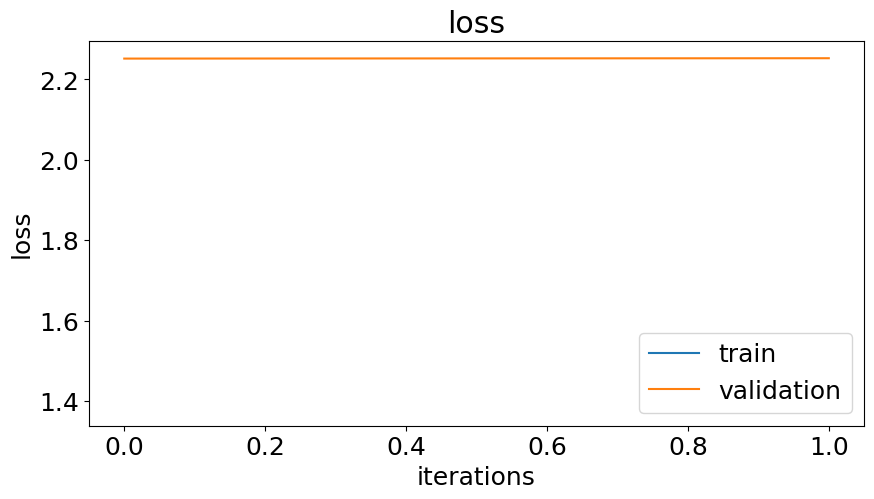

kappa=0.0


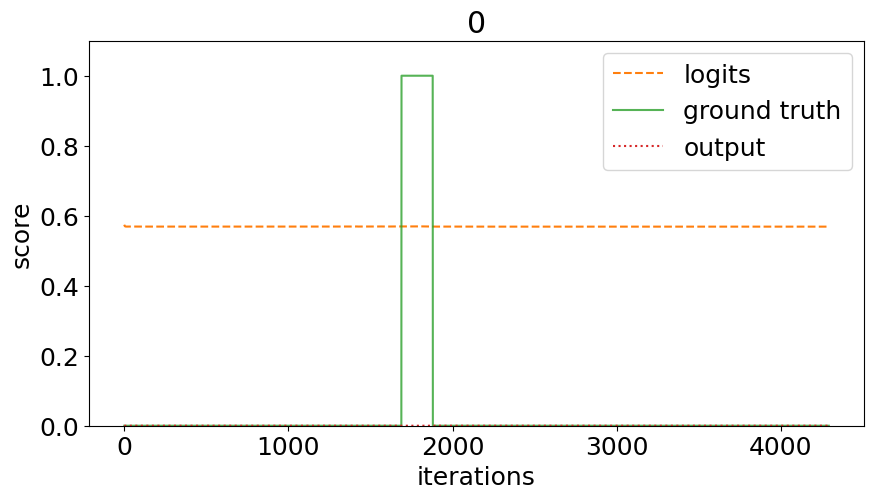

0.0
0.0


In [16]:
k = 2
n_epochs = 1

input_size = dataset[0][0].shape[1]
hidden_size = 32
num_layers = 1
lr = 0.001
weight_decay = 0
l1_sigma = 1e-06
dropout_rate = 0
pos_weight = compute_pos_weight(train_loader)

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

metrics = k_fold(dataset, 
                 model, 
                 criterion, 
                 device, 
                 lr, 
                 weight_decay, 
                 create_preds,
                 k, 
                 n_epochs, 
                 l1_sigma, 
                 batch_size=128, 
                 disable_pbar=False)

print(metrics)

def comptue_score(logits, labels):
      logits = torch.sigmoid(logits).detach()
      preds = create_preds(logits)
      return compute_kappa_score(preds, labels)

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

patience=3
delta=1e-5
model_path = '../models/lstm.pt'
early_stopping = EarlyStopping(model_path, patience, delta)


train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      compute_objective=comptue_score,
      n_epochs=n_epochs,
      l1_sigma=l1_sigma,
      direction="maximize",
      patience=patience,
      delta=delta,
      model_path=model_path)

f1 = []
kappa = []

model.eval()
with torch.no_grad():
      for idx in np.random.choice(len(test_set), len(test_set), replace=False): 
            testing_data = test_set[idx]
            logits = torch.sigmoid(model(testing_data[0].to(device))).detach().cpu()
            preds = create_preds(logits.unsqueeze(0))
            print(f'kappa={compute_kappa_score(preds == 1, testing_data[1].unsqueeze(0)).item()}')

            plt.title(idx)
            plt.plot(logits.numpy(), label='logits', linestyle='--' )
            plt.plot(testing_data[1], label='ground truth', alpha=0.8)
            plt.plot(preds.squeeze(), label='output', linestyle=':')
            
            plt.legend()
            plt.ylim(0, 1.1)
            plt.show()

      for (x_batch, shotnon), y_batch in val_loader :
            x_batch = x_batch.to(device)
            
            logits = torch.sigmoid(model(x_batch)).detach().cpu()
            preds = create_preds(logits)

            f1 += compute_f1(preds, y_batch)
            kappa += compute_kappa_score(preds, y_batch)

print(np.mean(f1))
print(np.mean(kappa))


In [ ]:
def comptue_score(logits, labels):
      logits = torch.sigmoid(logits).detach()
      preds = create_preds(logits)
      return compute_kappa_score(preds, labels)

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      compute_objective=comptue_score,
      n_epochs=n_epochs,
      l1_sigma=l1_sigma,
      direction="maximize",
      patience=1,
      delta=delta,
      model_path=model_path)

f1 = []
kappa = []

model.eval()
with torch.no_grad():
      for idx in np.random.choice(len(test_set), len(test_set), replace=False): 
            testing_data = test_set[idx]
            logits = torch.sigmoid(model(testing_data[0].to(device))).detach().cpu()
            preds = create_preds(logits.unsqueeze(0))
            print(f'kappa={compute_kappa_score(preds == 1, testing_data[1].unsqueeze(0)).item()}')

            plt.title(idx)
            plt.plot(logits.numpy(), label='logits', linestyle='--' )
            plt.plot(testing_data[1], label='ground truth', alpha=0.8)
            plt.plot(preds.squeeze(), label='output', linestyle=':')
            
            plt.legend()
            plt.ylim(0, 1.1)
            plt.show()

      for (x_batch, shotno), y_batch in val_loader :
            x_batch = x_batch.to(device)
            
            logits = torch.sigmoid(model(x_batch)).detach().cpu()
            preds = create_preds(logits)

            f1 += compute_f1(preds, y_batch)
            kappa += compute_kappa_score(preds, y_batch)

print(np.mean(f1))
print(np.mean(kappa))

  4%|▍         | 12/300 [00:02<00:48,  5.89it/s, score=0, train_loss=1.21]